In [27]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from imblearn.over_sampling import SMOTE

# Load data
df = pd.read_csv("C:\\Users\\ASUSTK\\OneDrive - Humber College\\3. Semester 3\\Machine Learning 1\\Group\\fraud_transactions_dataset.csv")

In [28]:
# STEP 1 - EDA (Exploratory Data Analysis)
# Check the dimension of the dataset
print('Dimension of the DataFrame (no of rows, no of columns):', df.shape)

# Check for duplicate rows and remove them
duplicates = df.duplicated().sum()
print(f'Number of duplicate rows: {duplicates}')
df = df.drop_duplicates()

# Identify missing data in each column
missing_data = df.isnull().sum()
print("Missing data in each column:", missing_data)

Dimension of the DataFrame (no of rows, no of columns): (1000, 7)
Number of duplicate rows: 0
Missing data in each column: Transaction Amount    0
Customer Age Group    0
Merchant Category     0
Transaction Time      0
Payment Method        0
Risk Score            0
Fraudulent            0
dtype: int64


In [29]:
# Detect and remove outliers using the IQR method
outliers_dict = {}
for column in df.select_dtypes(include=['float64', 'int64']).columns:
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    outliers_dict[column] = len(outliers)
    df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

print("\nNumber of outliers for each numerical feature:")
for column, count in outliers_dict.items():
    print(f'{column}: {count}')

print('Dimension of the DataFrame after removing outliers:', df.shape)



Number of outliers for each numerical feature:
Transaction Amount: 99
Risk Score: 0
Fraudulent: 0
Dimension of the DataFrame after removing outliers: (901, 7)


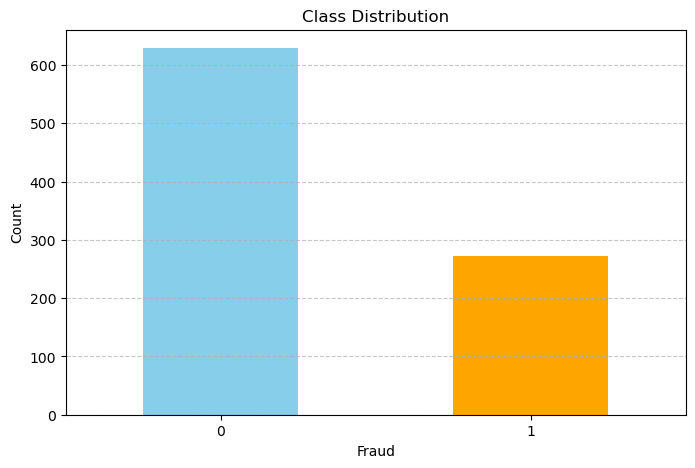

In [40]:
# Assuming 'y' is the original target variable (before balancing)
class_counts = y.value_counts()

# Create a bar plot
plt.figure(figsize=(8, 5))
class_counts.plot(kind='bar', color=['skyblue', 'orange'])
plt.title('Class Distribution')
plt.xlabel('Fraud')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [32]:
# Convert categorical variables to numeric
for column in df.select_dtypes(include=['object']):
    df[column] = df[column].astype('category').cat.codes

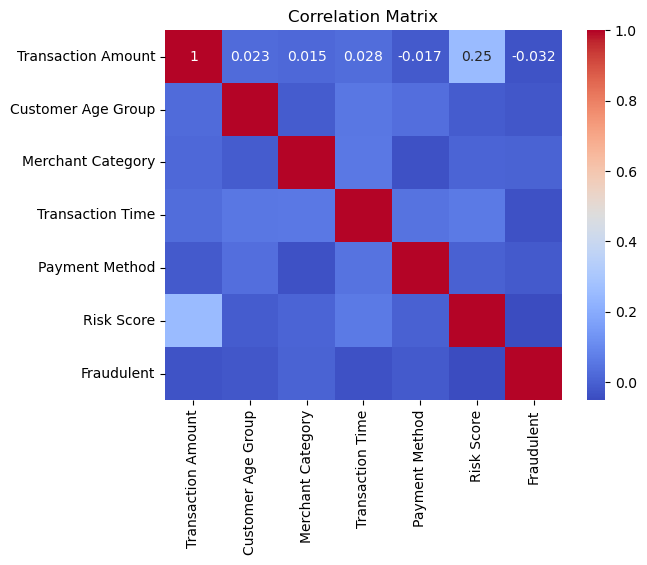

In [34]:
# Visualize the correlation matrix
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

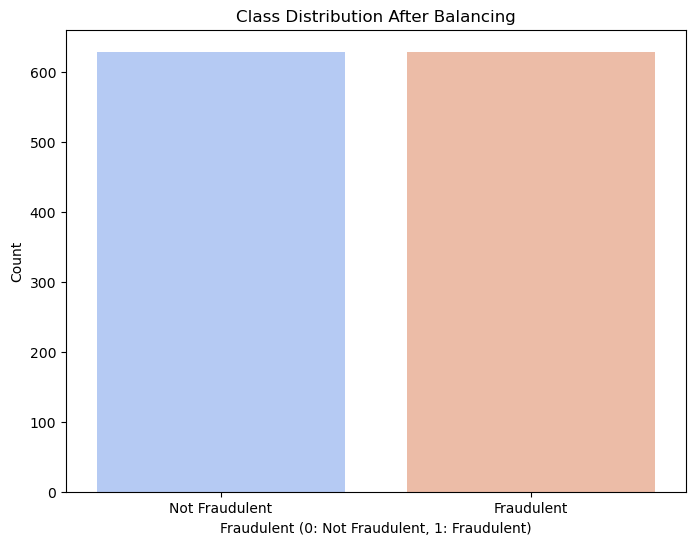

In [8]:
# STEP 2: Feature Engineering and Balancing the Data
# Generate interaction terms
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_poly = pd.DataFrame(poly.fit_transform(df.drop(columns=['Fraudulent'])))
X_poly.columns = poly.get_feature_names_out(df.drop(columns=['Fraudulent']).columns)
df = pd.concat([X_poly, df['Fraudulent'].reset_index(drop=True)], axis=1)

# Separate features and target variable
X = df.drop(columns=['Fraudulent'])
y = df['Fraudulent']

# Balance the dataset using SMOTE
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X, y)

# Visualize the balanced data
plt.figure(figsize=(8, 6))
sns.countplot(x=y_balanced, palette='coolwarm')
plt.title('Class Distribution After Balancing')
plt.xlabel('Fraudulent (0: Not Fraudulent, 1: Fraudulent)')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Not Fraudulent', 'Fraudulent'])
plt.show()

In [9]:
# Normalize the data
scaler = StandardScaler()
X_balanced = pd.DataFrame(scaler.fit_transform(X_balanced), columns=X.columns)

In [20]:
# STEP 3: Train and Optimize Models
# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42, stratify=y_balanced)

# Logistic Regression with Hyperparameter Tuning
log_reg = LogisticRegression(random_state=42, max_iter=1000)
param_grid_log = {'C': [0.1, 1, 10], 'penalty': ['l2']}
grid_log = GridSearchCV(log_reg, param_grid_log, cv=5, scoring='accuracy')
grid_log.fit(X_train, y_train)
log_best_model = grid_log.best_estimator_
y_pred_log = log_best_model.predict(X_test)
log_accuracy = accuracy_score(y_test, y_pred_log)
log_f1 = f1_score(y_test, y_pred_log)

# K-Nearest Neighbors with Hyperparameter Tuning
knn = KNeighborsClassifier()
param_grid_knn = {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance']}
grid_knn = GridSearchCV(knn, param_grid_knn, cv=5, scoring='accuracy')
grid_knn.fit(X_train, y_train)
knn_best_model = grid_knn.best_estimator_
y_pred_knn = knn_best_model.predict(X_test)
knn_accuracy = accuracy_score(y_test, y_pred_knn)
knn_f1 = f1_score(y_test, y_pred_knn)

print(f'Logistic Regression Accuracy: {log_accuracy:.4f}')
print(f'Logistic Regression F1 Score: {log_f1:.4f}')

print("KNN - Best Hyperparameters:", grid_knn.best_params_)
print(f'KNN Accuracy: {knn_accuracy:.4f}')
print(f'KNN F1 Score: {knn_f1:.4f}')

Logistic Regression Accuracy: 0.6296
Logistic Regression F1 Score: 0.6535
KNN Accuracy: 0.6772
KNN F1 Score: 0.7123


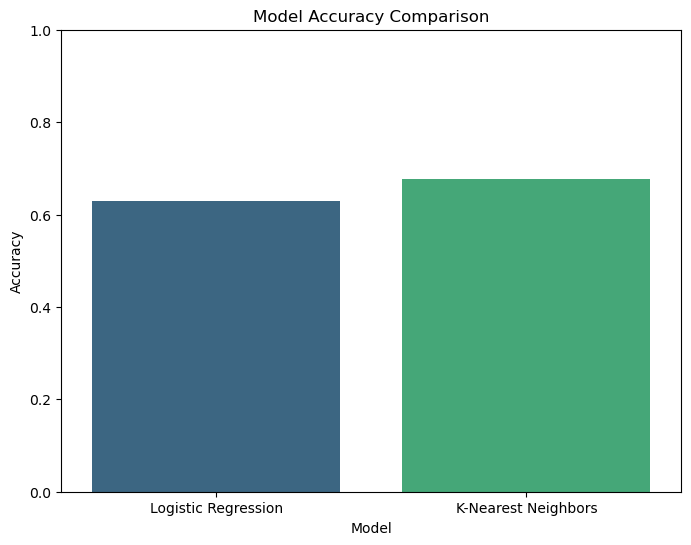

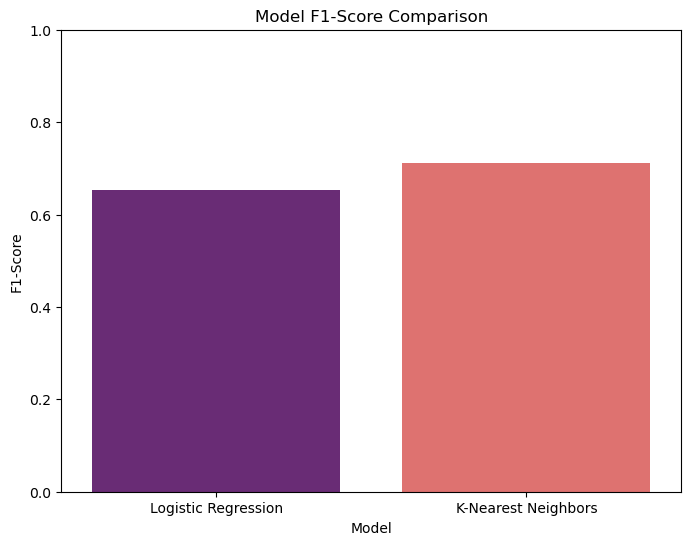

In [19]:
# STEP 4: Compare Models
# Accuracy comparison
accuracy_comparison = pd.DataFrame({
    'Model': ['Logistic Regression', 'K-Nearest Neighbors'],
    'Accuracy': [log_accuracy, knn_accuracy],
    'F1-Score': [log_f1, knn_f1]
})

# Visualization of model performance
plt.figure(figsize=(8, 6))
sns.barplot(x='Model', y='Accuracy', data=accuracy_comparison, palette='viridis')
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Ensure y-axis is from 0 to 1
plt.show()

plt.figure(figsize=(8, 6))
sns.barplot(x='Model', y='F1-Score', data=accuracy_comparison, palette='magma')
plt.title('Model F1-Score Comparison')
plt.ylabel('F1-Score')
plt.ylim(0, 1)
plt.show()

In [35]:
# STEP 6: Final Output
# Print evaluation metrics
print("\n--- Logistic Regression Results ---")
print(f"Accuracy: {log_accuracy:.2f}, F1-Score: {log_f1:.2f}")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_log))
print("Classification Report:\n", classification_report(y_test, y_pred_log))

print("\n--- K-Nearest Neighbors Results ---")
print(f"Accuracy: {knn_accuracy:.2f}, F1-Score: {knn_f1:.2f}")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_knn))
print("Classification Report:\n", classification_report(y_test, y_pred_knn))

# Print the best model
best_model = "Logistic Regression" if log_accuracy > knn_accuracy else "K-Nearest Neighbors"
best_accuracy = max(log_accuracy, knn_accuracy)
print(f"\n--- Best Model ---")
print(f"The best model is: {best_model} with an accuracy of {best_accuracy:.2f}")



--- Logistic Regression Results ---
Accuracy: 0.63, F1-Score: 0.65
Confusion Matrix:
 [[106  83]
 [ 57 132]]
Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.56      0.60       189
           1       0.61      0.70      0.65       189

    accuracy                           0.63       378
   macro avg       0.63      0.63      0.63       378
weighted avg       0.63      0.63      0.63       378


--- K-Nearest Neighbors Results ---
Accuracy: 0.68, F1-Score: 0.71
Confusion Matrix:
 [[105  84]
 [ 38 151]]
Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.56      0.63       189
           1       0.64      0.80      0.71       189

    accuracy                           0.68       378
   macro avg       0.69      0.68      0.67       378
weighted avg       0.69      0.68      0.67       378


--- Best Model ---
The best model is: K-Nearest Neighbors with an accuracy of